# 선형회귀: 보험료 예측하기

선형 회귀 모델로 보험 데이터셋을 학습해 보험료를 예측하고, 선형 회귀의 작동 원리를 이해

- 선형 회귀는 가장 기초적인 머신러닝 모델
- 종속변수가 연속형 변수인 것을 예측
> 범주형 변수: 명목척도(성별, 혈액형), 서열척도(학년, 만족도)로 이루어진 변수
>
> 연속형 변수: 등간척도(온도, 연도), 비율척도(나이, 키)로 이루어진 변수

- 장점
    - 모델이 간단하기 때문에 구현과 해석이 쉬움
    - 같은 이유로 모델링하는 데 오랜 시간이 걸리지 않음
- 단점
    - 최신 알고리즘에 비해 예측력이 떨어짐
    - 독립변수와 예측변수의 선형관계를 전제로 하기 때문에, 이러한 전제에서 벗어나는 데이터에서는 좋은 예측을 보여주기 어려움

## 한눈에 보는 예측 목표

- 보험 데이터셋을 이용하여 보험사에서 청구할 보험료를 예측
- 보험사에서 청구하는 병원 비용이 종속변수이며, 나이, 성별, BM, 자녀 수, 흡연 여부를 독립변수로 사용

## 코드실행

In [1]:
# 라이브러리 및 데이터 불러오기
import pandas as pd

file_url = 'https://media.githubusercontent.com/media/musthave-ML10/data_source/main/insurance.csv'

In [2]:
data=pd.read_csv(file_url)

In [4]:
# 데이터 확인하기
data

,age,sex,bmi,children,smoker,charges
0,19,0,27.900,0,1,16884.92400
1,18,1,33.770,1,0,1725.55230
2,28,1,33.000,3,0,4449.46200
3,33,1,22.705,0,0,21984.47061
4,32,1,28.880,0,0,3866.85520
...,...,...,...,...,...,...
1333,50,1,30.970,3,0,10600.54830
1334,18,0,31.920,0,0,2205.98080
1335,18,0,36.850,0,0,1629.83350
1336,21,0,25.800,0,0,2007.94500


In [5]:
data.head()

# age: 나이
# sex: 0(여자), 1(남자)
# bmi
# children: 자녀수
# smoker: 0(비흡연자), 1(흡연자)

,age,sex,bmi,children,smoker,charges
0,19,0,27.900,0,1,16884.92400
1,18,1,33.770,1,0,1725.55230
2,28,1,33.000,3,0,4449.46200
3,33,1,22.705,0,0,21984.47061
4,32,1,28.880,0,0,3866.85520


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   int64  
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   int64  
 5   charges   1338 non-null   float64
dtypes: float64(2), int64(4)
memory usage: 62.8 KB


In [7]:
data.describe()

# data.describe(include='all')
# 수치형 변수만 아니라 범주형 변수도 보여줌

,age,sex,bmi,children,smoker,charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.505232,30.663397,1.094918,0.204783,13270.422265
std,14.049960,0.500160,6.098187,1.205493,0.403694,12110.011237
min,18.000000,0.000000,15.960000,0.000000,0.000000,1121.873900
25%,27.000000,0.000000,26.296250,0.000000,0.000000,4740.287150
50%,39.000000,1.000000,30.400000,1.000000,0.000000,9382.033000
75%,51.000000,1.000000,34.693750,2.000000,0.000000,16639.912515
max,64.000000,1.000000,53.130000,5.000000,1.000000,63770.428010


In [8]:
round(data.describe(),2)

,age,sex,bmi,children,smoker,charges
count,1338.00,1338.00,1338.00,1338.00,1338.0,1338.00
mean,39.21,0.51,30.66,1.09,0.2,13270.42
std,14.05,0.50,6.10,1.21,0.4,12110.01
min,18.00,0.00,15.96,0.00,0.0,1121.87
25%,27.00,0.00,26.30,0.00,0.0,4740.29
50%,39.00,1.00,30.40,1.00,0.0,9382.03
75%,51.00,1.00,34.69,2.00,0.0,16639.91
max,64.00,1.00,53.13,5.00,1.0,63770.43


사분위수 ; 데이터를 작은 값부터 큰 값까지 순서대로 나열했을 때 이를 4등분하는 값
- iqr = Q3 - Q1 (중앙 50%값을 의미)
- iqr은 보통 이상치 탐지할 때 사용 (Q1 - 1.5 * IQR 과 Q3 + 1.5 * IQR 을 이용)

### 전처리

1. 종속변수와 독립변수 분리
- 보통 labeled train data set을 사용
- 지도학습에 속하는 머신러닝 모델은 독립변수로 종속변수를 예측
2. Train set 과 Test Set으로 분리
- 학습에 사용한 데이터와 평가에 사용하는 데이터를 분리
- Test set을 훈련 모델에 사용시 Data Leakage 발생
    - Data Leakage가 발생하면 실제 성능은 낮은데, 평가 점수만 높게 나와 과적합처럼 보이는 문제가 발생
- 일반적으로 7:3, 8:2의 비율로 나눔
    - 데이터의 크기에 따라, 비율을 조정할 수 있음

In [14]:
# 데이터 나누기
X = data[['age', 'sex', 'bmi', 'children', 'smoker']]
y = data['charges']

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
# 8:2의 비율로 분리
# random_state를 부여하여 매번 다르게 분리되는 것을 같게해줌

### 모델링

머신러닝 알고리즘으로 모델을 학습시키는 과정

In [16]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

#### 하이퍼파라미터

1. fit_intercept (bool, default=True)
- 절편 β0을 포함할지 여부
- False로 두면 데이터가 원점(0,0)을 지난다고 가정

2. n_jobs (int, default=None)
- CPU 병렬 처리 설정
- n_jobs=-1로 두면 모든 코어 사용

3. positive (bool, default=False)
- 회귀계수를 강제로 양수(positive)만 되게 할지 여부
- 수요량, 가격 등 음수가 불가능한 상황에서 유용

오버피팅(overfitting): 과적합(과대적합)
- 모델이 train set에 지나치게 잘 맞도록 학습되어 예측력이 떨어지는 현상

In [17]:
# 모델을 활용해 예측하기

pred = model.predict(X_test)

### 예측 모델 평가하기

In [18]:
# 테이블로 평가하기

comparison = pd.DataFrame({'actual': y_test, 'pred': pred})
comparison

# 하나하나 확인해야하는 한계가 있음

,actual,pred
12,1826.84300,4765.249466
306,20177.67113,4957.730865
318,7421.19455,8298.988153
815,1877.92940,3078.811868
157,15518.18025,24165.956542
...,...,...
713,1984.45330,5776.764928
1282,14283.45940,23102.847340
531,14043.47670,14280.732585
537,8825.08600,10527.417291


<AxesSubplot:xlabel='actual', ylabel='pred'>

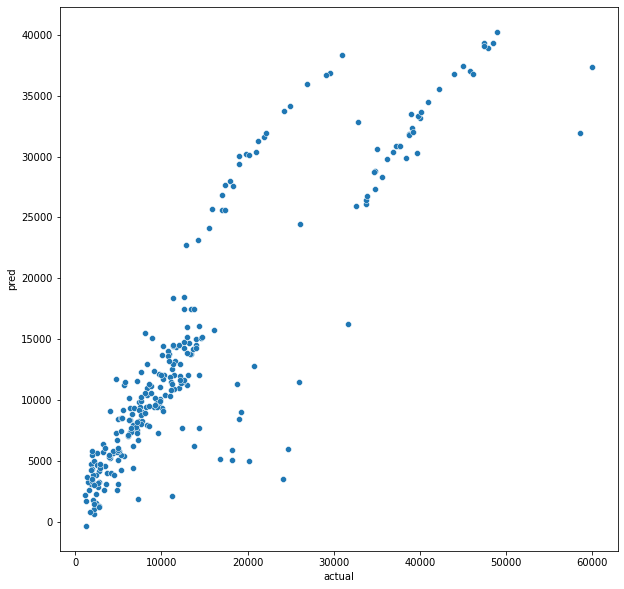

In [21]:
# 그래프로 평가하기

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,10))
sns.scatterplot(x='actual', y='pred', data=comparison)

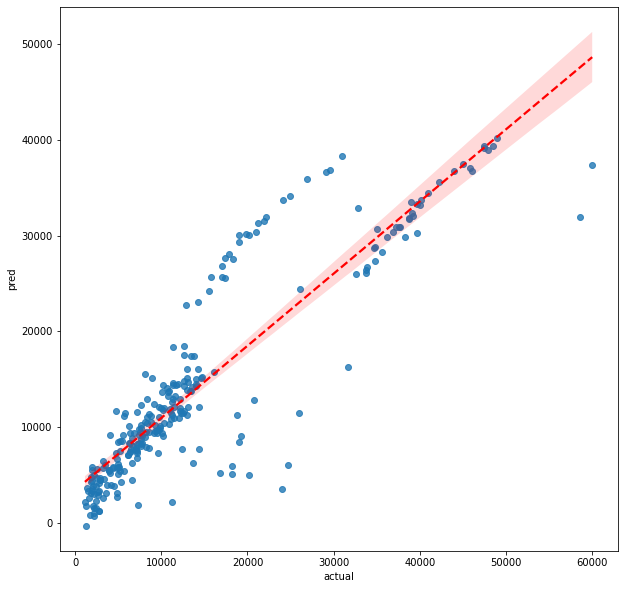

In [26]:
plt.figure(figsize=(10,10))

sns.regplot(
    x='actual', 
    y='pred', 
    data=comparison, 
    scatter=True, 
    line_kws={'color':'red', 'linestyle':'--'}  # 점선 스타일
)
plt.show()

그래프 평가는 직관적으로는 되지만 객관적인 기준이 되지는 않음

In [28]:
# 통계적인 방법으로 평가하기: RMSE
# RMSE(평균 제곱근 오차): 실제값과 예측값 사이의 차이를 제곱 평균한 뒤 제곱근을 취한 값
# 오차를 제곱하기 때문에 큰 오차에 더 민감
# 값이 작을수록 좋음

# RMSE 외에도 MAE, MSE 등의 평가지표가 있음
# MAE: 평균 절대 오차
# MSE: 평균 제곱 오차
# R^2: 결정계수

from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, pred) ** 0.5

5684.927776334484

In [29]:
mean_squared_error(y_test, pred, squared=False)

5684.927776334484

In [30]:
# RMSE를 평가하는데 절대적인 기준이 없어 5684라는 값이 크거나 작다고 할 수 없음
# RMSE는 상대평가

# R^2는 독립변수로 설명되는 종속변수의 분산 비율을 나타내는 통계적 측정값
# 모델의 설명력이라고 이해하면 쉬움
# 0에서 1 사이의 값으로 1에 가까울수록 모형을 잘 설명하고 있음

model.score(X_train, y_train)

0.7368220127747351

In [31]:
# 이해하기
# 키와 체중을 대표적인 선형 관계라 생각할 수 있음(키가 크면 체중이 많이 나감)
# 산점도가 주어졌을 때 사람마다 최적의 선이라 판단되는게 직관적으로 다를 것임
# 머신러닝에서는 손실함수를 최소화하는 선을 찾아서 모델을 만들어 냄
# 손실함수(Loss Function): 예측값과 실제값 차이(오차)를 평가하는 방법 -> ex) RMSE

# 선형회귀는 상대적으로 단순한 알고리즘이라 수식으로 표현하기 쉬움
# 독립변수가 1개일 때는 그래프로 그리기 쉽지만, 여러 개일 떄는 그리긴 어려워도 수식으로 표현가능

In [33]:
# 각 독립변수의 계수 확인
model.coef_

array([2.64799803e+02, 1.73446608e+01, 2.97514806e+02, 4.69339602e+02,
       2.34692802e+04])

In [34]:
pd.Series(model.coef_, index=X.columns)

age           264.799803
sex            17.344661
bmi           297.514806
children      469.339602
smoker      23469.280173
dtype: float64

In [35]:
# 해석 방법
# age가 1만큼 증가면 charges는 264.799803... 만큼 증가
# sex와 같은 범주형 변수에서는 0보다 1에서 charges가 17.344661... 만큼 높음

In [36]:
model.intercept_ # y절편

-11576.999976112367

위 해석 방식으로 수식은 다음과 같음

charges = 264.799803 * age + 17.344661 * sex + 297.514806 * bmi + 469.339602 * children + 23469.280173 * smoker -11576.999976112367

- 부호와 상관없이 계수의 절댓값이 클수록 영향이 크고, 0에 가까울수록 영향이 자긍ㅁ
- 계수간 비교와는 다른 개념임
- 각 변수의 scale이 다르기 때문

### 추가 내용

In [39]:
# 릿지 회귀
from sklearn.linear_model import Ridge

# 라쏘 회귀
from sklearn.linear_model import Lasso

# 엘라스틱 넷
from sklearn.linear_model import ElasticNet

릿지 회귀(L2 정규화)
- 회귀계수가 너무 커지지 않도록 제약을 줌 -> 과적합 방지
- 다중공선성이 있거나 대부분의 변수가 유용하다고 판단할 때 사용
- 규제 강도($\alpha$)를 잘못 설정하면 과소적합의 위험이 있음

라쏘 회귀(L1 정규화)
- 필요 없는 변수를 아예 제거해버림
- 변수 선택, 일부 변수만 중요하다고 판단되는 경우(고차원 데이터)
- 변수간 해석 왜곡 가능성이 있고 과도하게 제거하면 성능이 떨어질 수 있음

엘라스틱넷 회귀
- 릿지 + 라쏘
- 릿지의 안정성과 라쏘의 변수선택 결합
- 변수들 간의 상관관계가 크고 불필요한 변수도 많을 때 사용
- 두 개의 모델을 혼합한 것이라 튜닝 난이도가 있고, 각각의 단점도 일부 공유함

### 연습 문제
1. (3)  
2. (2) -> 시험셋은 모델 학습에 사용하면 안됨
3. (1) -> AUC는 ROC 곡선의 아래 면적으로 분류에서 사용
4. (3) -> 계수의 절대값의 크기가 클수록 영향도가 크다고 할 수 있음

# 질문
여러 가지 평가 지표(RMSE, MAE, $R^2$ 등) 중에서 우선순위가 정해져 있는지 궁금합니다. 만약 정해져 있지 않다면, 어떤 기준으로 평가 지표를 선택하는 것이 좋을까요?